In [3]:
from tensorflow.keras import layers, models 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

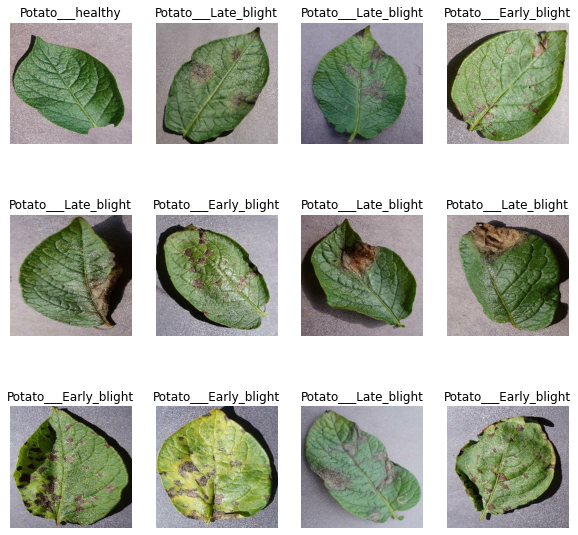

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### 80% ==> Training
### 20% ==> 10% ==> Cross Validation, 10% ==> Testing

In [8]:
def get_datset_partitions_df(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        df = df.shuffle(shuffle_size, seed=12)
    ds_size = len(df)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = df.take(train_size)
    val_ds = df.skip(train_size).take(val_size)
    test_ds = df.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_datset_partitions_df(dataset)

In [10]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_shape), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


C:\Users\Public\Python\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


54/54 [==============================] - 95s 2s/step - loss: 0.8627 - accuracy: 0.5312 - val_loss: 0.7182 - val_accuracy: 0.5938
Epoch 2/50
54/54 [==============================] - 78s 1s/step - loss: 0.6114 - accuracy: 0.7303 - val_loss: 0.4656 - val_accuracy: 0.8542
Epoch 3/50
54/54 [==============================] - 85s 2s/step - loss: 0.3266 - accuracy: 0.8698 - val_loss: 0.2009 - val_accuracy: 0.9427
Epoch 4/50
54/54 [==============================] - 81s 1s/step - loss: 0.3129 - accuracy: 0.8738 - val_loss: 0.1839 - val_accuracy: 0.9375
Epoch 5/50
54/54 [==============================] - 78s 1s/step - loss: 0.2512 - accuracy: 0.8999 - val_loss: 0.1680 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 83s 2s/step - loss: 0.1916 - accuracy: 0.9311 - val_loss: 0.2595 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 94s 2s/step - loss: 0.0917 - accuracy: 0.9653 - val_loss: 0.2608 - val_accuracy: 0.9062
Epoch 8/50
54/54 [=============

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 329ms/step - loss: 0.0722 - accuracy: 0.9805


In [19]:
scores

[0.07222524285316467, 0.98046875]

In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
len(history.history['accuracy'])

50

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

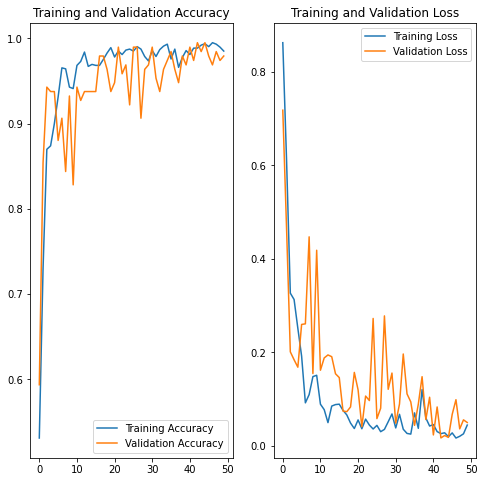

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

First Image to Predict
First Image's Actual Label: Potato___Early_blight
1/1 [==============================] - 1s 816ms/step
Predicted Label: Potato___Early_blight


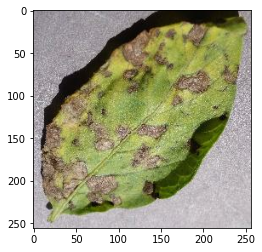

In [26]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print('First Image to Predict')
    plt.imshow(first_image)
    print(f'First Image\'s Actual Label: {class_names[first_label]}')
    
    batch_prediction = model.predict(image_batch)
    print(f'Predicted Label: {class_names[np.argmax(batch_prediction[0])]}')

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


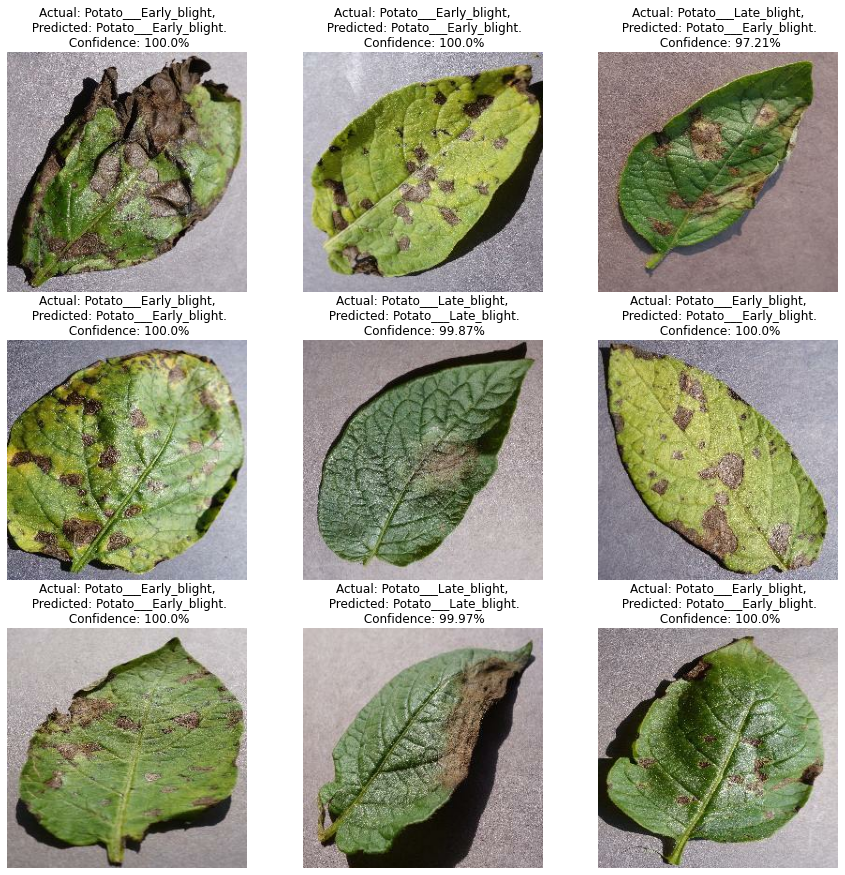

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"models/{model_version}")

In [36]:
import pickle

In [39]:
import pickle
with open('model_t.pickle', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://62ef21cd-0a43-4c45-9503-583ae4cb0d86/assets


INFO:tensorflow:Assets written to: ram://62ef21cd-0a43-4c45-9503-583ae4cb0d86/assets


In [34]:
model_loaded=pickle.load(open('model.pickle','rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'modelp.pickle'

In [ ]:
model_loaded.predict(test_ds)